<a href="https://colab.research.google.com/github/20hnu/ml_projects/blob/main/Emotional_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

 91% 55.0M/60.3M [00:00<00:00, 248MB/s]
100% 60.3M/60.3M [00:00<00:00, 242MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns
import random

from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Dropout,Flatten, Dense , GlobalAveragePooling2D,Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

In [ ]:
project_name = 'FER_2013_Emotion_Detection'

model_names = [
    'Custom_CNN_From_Scratch',
    "Custom_CNN_with_Augmentation",
    "VGG16_Transfer_Learing",
    "ResNet50_Transfer_Learning"
]

base_dir = '/content/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os.makedirs(model_dir, exist_ok=True)

print(f"Project Directory structure created at :{project_dir}")

Project Directory structure created at :/content/FER_2013_Emotion_Detection


##DATA CLEANING

In [ ]:
cnt = 0
image_exts = ['jpeg','jpg','png']

data_dir = '/content/train'

for root, dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)
    cnt += 1
    try:
      file_type = imghdr.what(file_path)

      if file_type not in image_exts:
        print(f'Image not in ext list {file_path}')
        os.remove(file_path)
      else:
         img = cv2.imread(file_path)

    except Exception as e:
      print(f"Issue with file {file_path},Error: {e}")
      os.remove(file_path)

print(cnt)

28709


In [ ]:
def count_files_in_subdirs(directory, set_name):
  counts={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)

    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  df = pd.DataFrame(counts, index=[set_name])
  return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir,'train')
print(train_count)

test_count = count_files_in_subdirs(train_dir,'test')
print(test_count)

       fear   sad  disgust  happy  neutral  surprise  angry
train  4097  4830      436   7215     4965      3171   3995
      fear   sad  disgust  happy  neutral  surprise  angry
test  4097  4830      436   7215     4965      3171   3995


<Axes: >

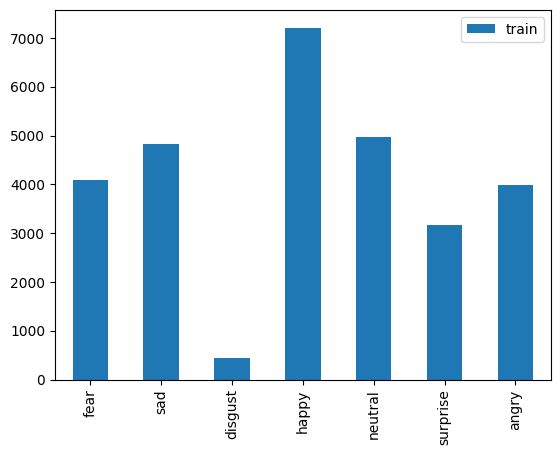

In [ ]:
train_count.transpose().plot(kind="bar")

<Axes: >

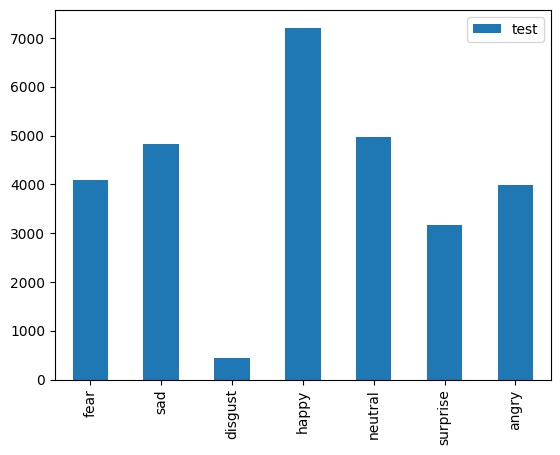

In [ ]:
test_count.transpose().plot(kind="bar")

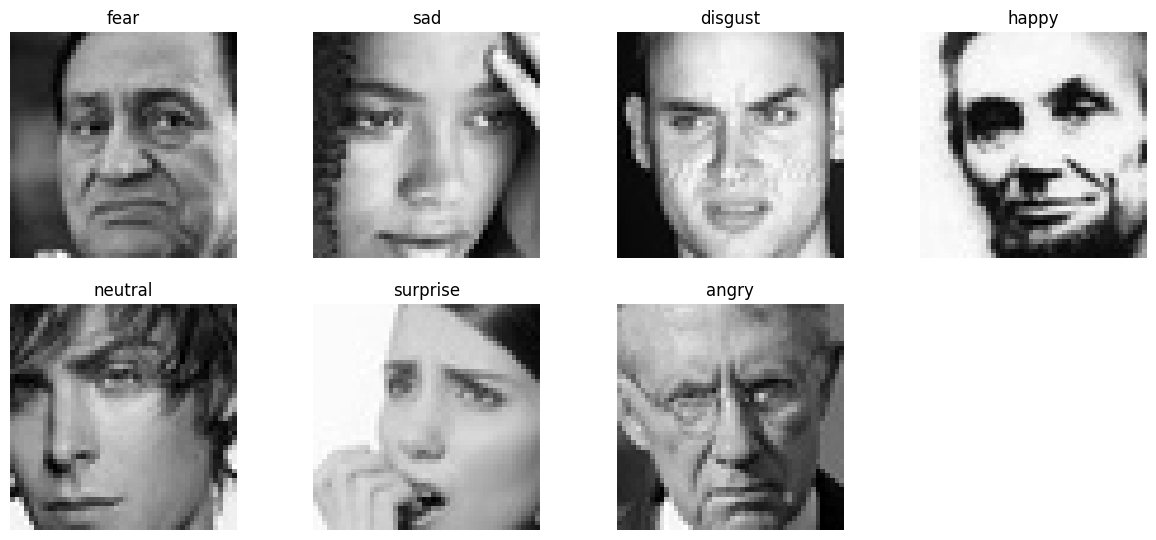

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize = (15,10))

for i, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[40])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img, cmap="gray")
  plt.title(emotion)
  plt.axis("off")

In [ ]:
def plot_images_from_directory(directory_path,class_name,num_images = 9):
  image_filenames = os.listdir(directory_path)

  if len(image_filenames) < num_images:
    print(f"Only found { len(image_filenames)} images in {directory_path}, displaying them all")
    num_images = len(image_filenames)

  selected_images = random.sample(image_filenames, num_images)
  fig,axes = plt.subplots(3,3 ,figsize=(8,8))
  axes = axes.ravel()


  for i, image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path, image_file)
    # image = Image.open(image_path)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_name}")
    axes[i].axis("off")

  plt.tight_layout()
  plt.show()

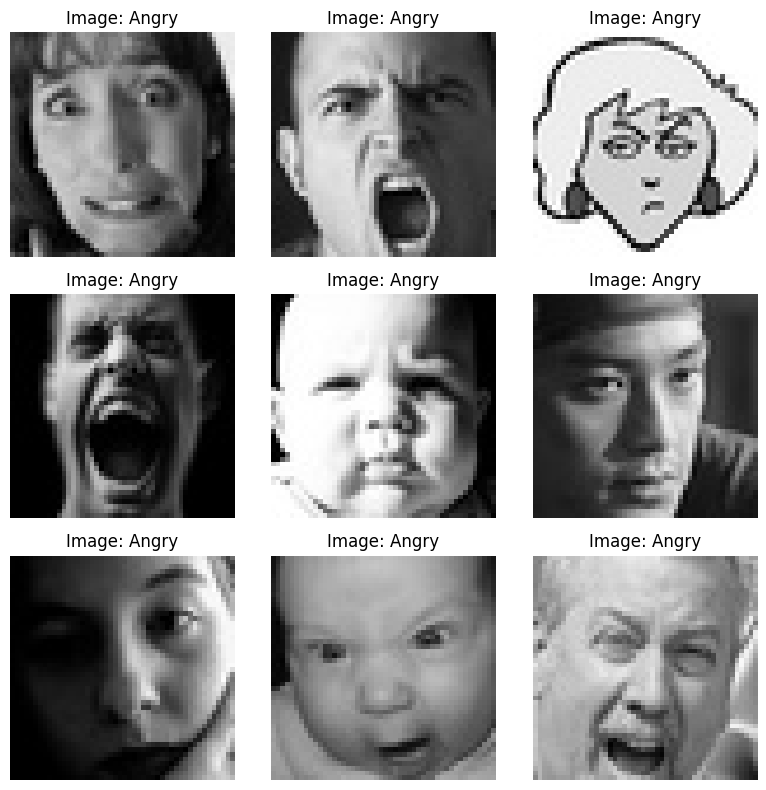

In [ ]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name="Angry")

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)

if img is not None:
  print("Shape", img.shape)
else:
  print("lorem epsum")

Shape (48, 48)


##Model Building


1. Custom CNN from Scratch

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
img_width, img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7


In [ ]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode ="categorical",
    color_mode = 'grayscale'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode ="categorical",
    color_mode = 'grayscale',
    subset="validation"
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode ="categorical",
    color_mode = 'grayscale'
)

Found 28709 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)
validation_class_labels = validation_generator.class_indices
print("validation class labels:", validation_class_labels)
test_class_labels = test_generator.class_indices
print("Testing class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Testing class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding="same",kernel_initializer ='glorot_uniform' ,input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(128, kernel_size = (3,3), padding="same", kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3,3), padding="same",kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))


model.add(Conv2D(512, kernel_size = (3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3,3), padding="same",kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
cnn_path="/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch"
name = "CustomCNN_model.keras"
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/CustomCNN_model.keras'

In [ ]:
# callback to save model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only = True,
                             verbose=1,
                             mode='min',
                             monitors="val_loss")

In [ ]:
# callback for early stopping
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                          min_delta=0.0001,
                          patience=6,
                          verbose=1,
                          factor=0.2)

In [ ]:
# callback to log training data to a csv file

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]



In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_per_epoch = validation_generator.samples //validation_generator.batch_size + 1
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(train_generator,steps_per_epoch = train_steps_per_epoch,epochs=10,validation_data=validation_generator, validation_steps=validation_steps_per_epoch,callbacks=callbacks)

Epoch 1/10
449/449 [==============================] - ETA: 0s - loss: 8.8983 - accuracy: 0.2691
Epoch 1: val_loss improved from inf to 9.96991, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/CustomCNN_model.keras
449/449 [==============================] - 46s 78ms/step - loss: 8.8983 - accuracy: 0.2691 - val_loss: 9.9699 - val_accuracy: 0.1996 - lr: 1.0000e-04
Epoch 2/10
449/449 [==============================] - ETA: 0s - loss: 6.6998 - accuracy: 0.3500
Epoch 2: val_loss improved from 9.96991 to 5.78575, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/CustomCNN_model.keras
449/449 [==============================] - 31s 70ms/step - loss: 6.6998 - accuracy: 0.3500 - val_loss: 5.7858 - val_accuracy: 0.3954 - lr: 1.0000e-04
Epoch 3/10
449/449 [==============================] - ETA: 0s - loss: 4.9927 - accuracy: 0.3936
Epoch 3: val_loss improved from 5.78575 to 4.26336, saving model to /content/FER_2013_Emotion_Detection/Custom_CNN_F

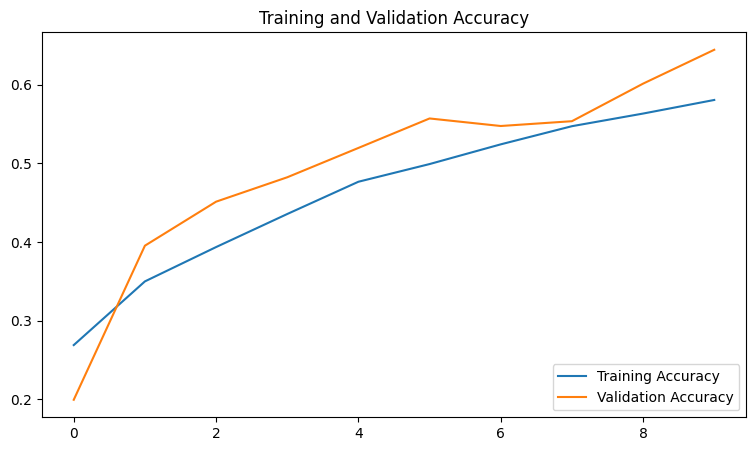

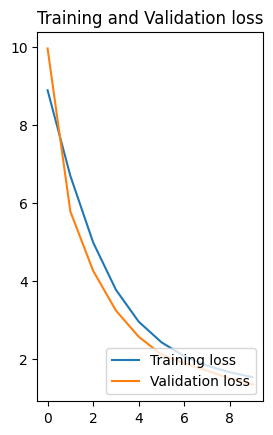

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label="Training Accuracy")
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Training loss")
plt.plot(epochs_range,val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and Validation loss")

plt.show()

113/113 [==============================] - 3s 26ms/step


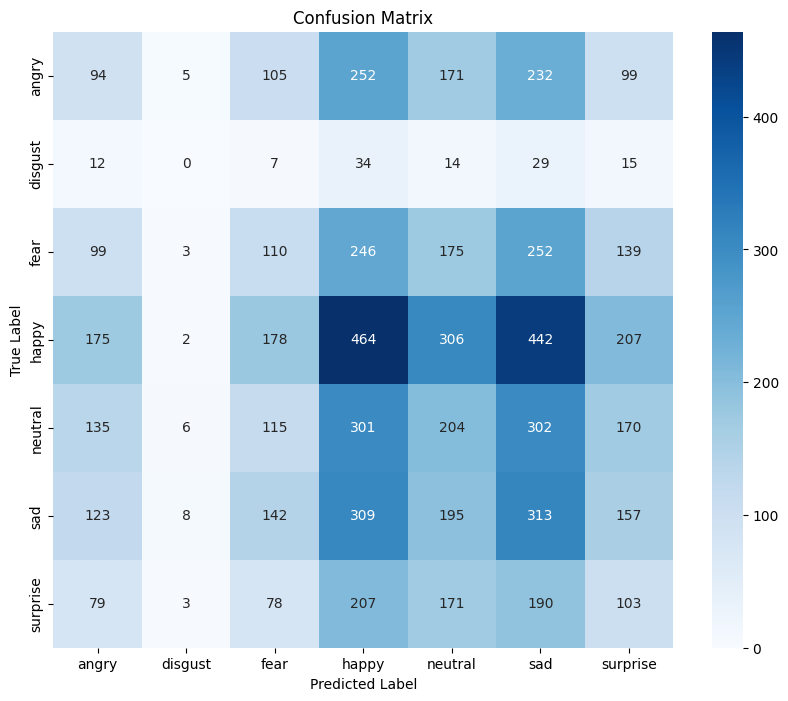

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.asarray(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)).argmax(axis=1))
class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.13      0.10      0.11       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.11      0.13      1024
       happy       0.26      0.26      0.26      1774
     neutral       0.17      0.17      0.17      1233
         sad       0.18      0.25      0.21      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.18      7178



In [ ]:
predicted_classes

array([3, 4, 4, ..., 5, 4, 5])

VGG16 Architecture

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width, img_height = 224,224
batch_size = 64
epochs = 10
num_classes = 7

data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    zoom_range =0.2,
                                    width_shift_range=0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip=True,
                                    fill_mode="nearest"
                                    # validation_split=0.2
                                    )

test_preprocessor = ImageDataGenerator(
    rescale=1/255.,
)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode ="categorical",
    color_mode = 'rgb',
    subset="training",
    shuffle=True
)


test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size = batch_size,
    class_mode ="categorical",
    color_mode ='rgb'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#Extract class labels for all instances in the training datasets
classes = np.array(train_generator.classes)

#calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes = 7

tf.keras.backend.clear_session()

vgg = VGG16(input_shape=(224,224,3), include_top=False, weights = 'imagenet')
vgg.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
for layer in vgg.layers[:-3]:
  layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
classes

7

In [ ]:
x = Flatten()(vgg.output)

x = Dense(1024, activation='relu', kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)

x = Dense(512, activation='relu', kernel_initializer = 'he_normal')(x)
x = Dropout(0.5)(x)

output = Dense(7, activation='softmax',kernel_initializer = 'he_normal')(x)

model = Model(inputs=vgg.input , outputs = output)


model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 =0.9, beta_2 = 0.999, amsgrad=False),
              metrics=['accuracy'])


model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
cnn_path="/content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning"
name = "CustomCNN_model.keras"
chk_path = os.path.join(cnn_path, name)

# callback to save model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only = True,
                             verbose=1,
                             mode='min',
                             monitors="val_loss")

# callback for early stopping
earlystop = EarlyStopping(monitor="val_loss",
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                          min_delta=0.0001,
                          patience=6,
                          verbose=1,
                          factor=0.2)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_per_epoch = validation_generator.samples //validation_generator.batch_size + 1
test_steps_per_epoch = test_generator.samples // test_generator.batch_size + 1



In [ ]:
history = model.fit(train_generator,steps_per_epoch = train_steps_per_epoch,epochs=5,validation_data=test_generator, validation_steps=test_steps_per_epoch,class_weight = class_weights_dict,callbacks=callbacks)

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.7189 - accuracy: 0.3290
Epoch 1: val_loss improved from inf to 1.51109, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/CustomCNN_model.keras
449/449 [==============================] - 502s 1s/step - loss: 1.7189 - accuracy: 0.3290 - val_loss: 1.5111 - val_accuracy: 0.4259 - lr: 1.0000e-04
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.5520 - accuracy: 0.4044
Epoch 2: val_loss improved from 1.51109 to 1.37928, saving model to /content/FER_2013_Emotion_Detection/VGG16_Transfer_Learning/CustomCNN_model.keras
449/449 [==============================] - 444s 988ms/step - loss: 1.5520 - accuracy: 0.4044 - val_loss: 1.3793 - val_accuracy: 0.4695 - lr: 1.0000e-04
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.4485 - accuracy: 0.4406
Epoch 3: val_loss did not improve from 1.37928
449/449 [==============================] - 454s 1s/step - loss: 1.4485 

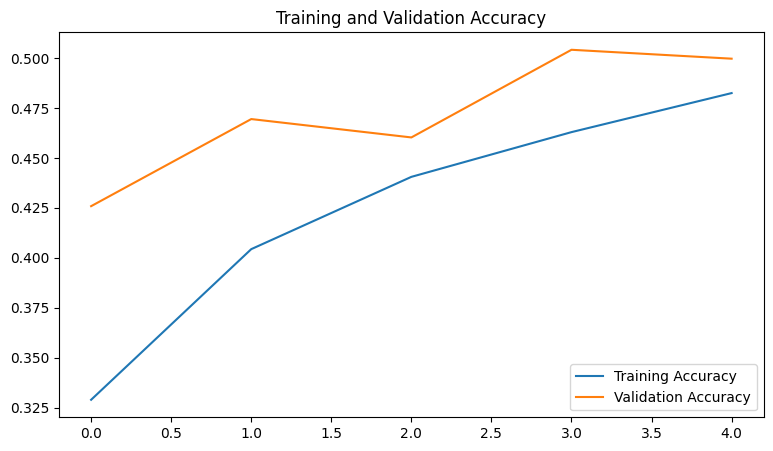

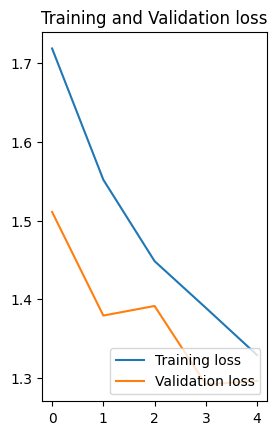

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label="Training Accuracy")
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label="Training loss")
plt.plot(epochs_range,val_loss,label="Validation loss")
plt.legend(loc="lower right")
plt.title("Training and Validation loss")

plt.show()

In [ ]:
train_loss , train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)


113/113 [==============================] - 32s 278ms/step - loss: 1.2962 - accuracy: 0.4997


113/113 [==============================] - 31s 275ms/step


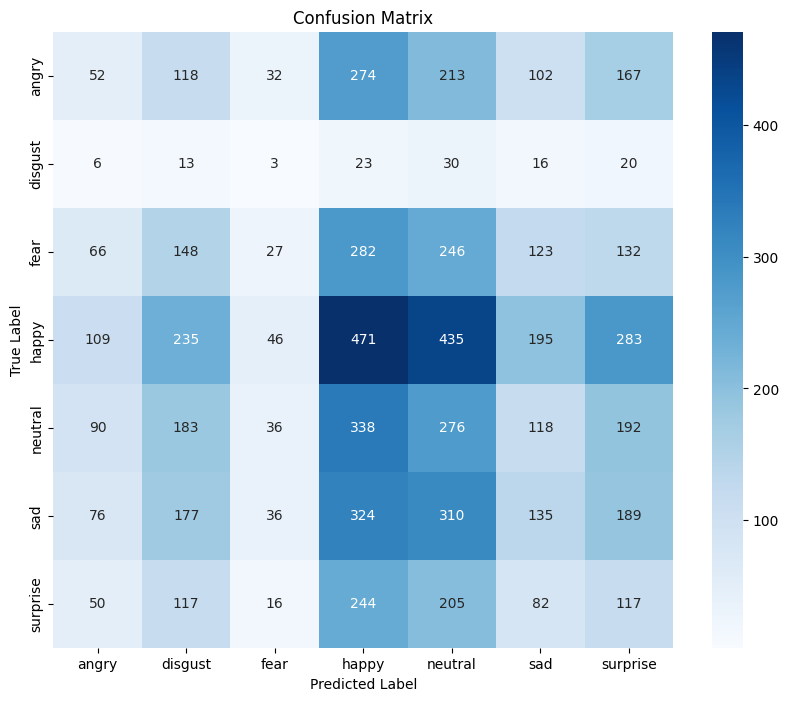

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.asarray(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)).argmax(axis=1))
class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(true_classes, predicted_classes)


plt.figure(figsize = (10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels = class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.12      0.05      0.07       958
     disgust       0.01      0.12      0.02       111
        fear       0.14      0.03      0.04      1024
       happy       0.24      0.27      0.25      1774
     neutral       0.16      0.22      0.19      1233
         sad       0.18      0.11      0.13      1247
    surprise       0.11      0.14      0.12       831

    accuracy                           0.15      7178
   macro avg       0.14      0.13      0.12      7178
weighted avg       0.17      0.15      0.15      7178



In [ ]:
model.save("vgg16.keras")

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes = list(test_generator.class_indices.keys())

113/113 [==============================] - 33s 292ms/step


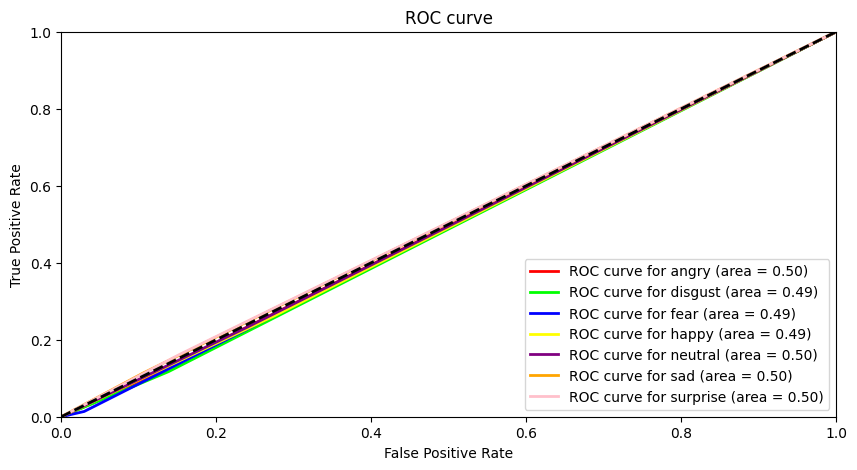

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr=dict()
tpr=dict()
roc_auc = dict()
for i in range(7):
  fpr[i],tpr[i] ,_ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10,5))
colors=    ['#FF0000','#00FF00','#0000FF', '#FFFF00', '#800080', '#FFA500', '#FFC0CB']
for i, color in enumerate(colors):
  plt.plot(fpr[i], tpr[i],color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_encoded

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
preds_encoded

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]])

###OPTUNA for hyperparameter tuning

In [1]:
# For deployment

!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.1 MB/s e

In [21]:
import numpy as np
from tensorflow.keras.utils import img_to_array, load_img
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.preprocessing import image

In [6]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Photos/vgg16.keras")

In [17]:
emotion_labels = {'angry':0,"disgust":1,'fear':2, "happy":3,"neutral":4,"sad":5,"surprise":6}
print(emotion_labels.items())
index_to_emotion = {v: k for k , v in emotion_labels.items()}
index_to_emotion

dict_items([('angry', 0), ('disgust', 1), ('fear', 2), ('happy', 3), ('neutral', 4), ('sad', 5), ('surprise', 6)])


'Unknown Emotion'

In [18]:

def prepare_image(img_pil):
  img = img_pil.resize((224,224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0
  return img_array

def predict_emotion(image):
  processed_image = prepare_image(image)

  prediction = model.predict(processed_image)
  prediction_class = np.argmax(prediction, axis=1)
  print(prediction_class)
  predicted_emotion = index_to_emotion.get(prediction_class[0],"Unknown Emotion")

  return predicted_emotion


interface = gr.Interface(
    fn = predict_emotion,
    inputs=gr.Image(type="pil"),
    outputs = "text",
    title="Emotional Detection",
    description = "Upload an image and see the predicted emotion"
)

interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5e0afea97fc4ab16cf.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
